# Activity analysis (Firing Rate)
'''
Created on Thru 04 Jun 2020'''

In this notebook we will compute mean values of activity as if they were firing rate to sort neurons acording to activity level, and compute further analysis using that information.

We will also do simple analysis separating objects exploratory behaviours and trials to seach for significant changes in firing rates.

NOTE: When comparing trials, or sessions take into account that firing rate values for a neuron is dependent on the registration procedure (if you are overclustering firing rate values will be lower than if you are underclustering).

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
cmap = cm.jet

In [124]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165           ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 100 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 1           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 20                 ## value of resampling

session_now = 1 
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [125]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_normed/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/mean_activity/'

In [126]:
firing_rate_vector = []   ## correlation matrix that will contain all the correlation matrix of multiple sessions
task_list = []            ## condition list
correlation_matrix = []
for session in sessions:
    
    ## define task for plotting. This will cahnge for other mice!!!!
    if mouse == 56165 or mouse == 32364:
        if session == 1:
            task1 = 'OVERLAPPING'
        else:
            if session == 2:
                task1 = 'STABLE'
            else:
                task1 = 'RANDOM'
                
    if mouse == 32365:
        sessions = [2,3] ## sessions for this particular mouse
        if session == 2:
            task1 = 'RANDOM'
        else:
            if session == 3:
                task1 = 'OVERLAPPING'
            
    if mouse == 56166:
        if session== 1:
            task1 = 'RANDOM'
        else:
            if session== 2:
                task1 = 'OVERLAPPING'
                
    if mouse == 32363:
        sessions = [1,2] ## sessions for this particular mouse
        if session == 1:
            task1 = 'RANDOM'
        else:
            if session== 2:
                task1 = 'OVERLAPPING'
    
    if mouse == 32366:
        sessions = 3 ## sessions for this particular mouse
        if session_now == 3:
            task1 = 'RANDOM'

    file_name_session_1 = 'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_1_v'+ f'{decoding_v}'+'.4.'+f'{100}'+\
                          '.'+f'{alignment_v}'+'.'+ f'{equalization_v}' +'.' + f'{source_extraction_v}'+'.' + \
                          f'{component_evaluation_v}' +'.'+ f'{registration_v}' + '.npy'
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_1_v'+ f'{decoding_v}'+'.4.'+f'{1}'+\
                          '.'+f'{0}'+ '.pkl'
    beh_file_name_1 = 'mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_event_'+f'{re_sf}'+'.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = activity.shape[1]
    ##normalize neural activity
    neural_activity1 = activity[1:,:]
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,re_sf=re_sf)
    firing_rate = np.mean(resample_neural_activity_mean,axis = 1)
    firing_rate_vector.append(firing_rate)
    positions = np.flip(np.argsort(firing_rate))
    correlation_matrix.append(stats.corr_matrix(neural_activity = resample_neural_activity_mean[positions,:]))
    task_list.append(task1)

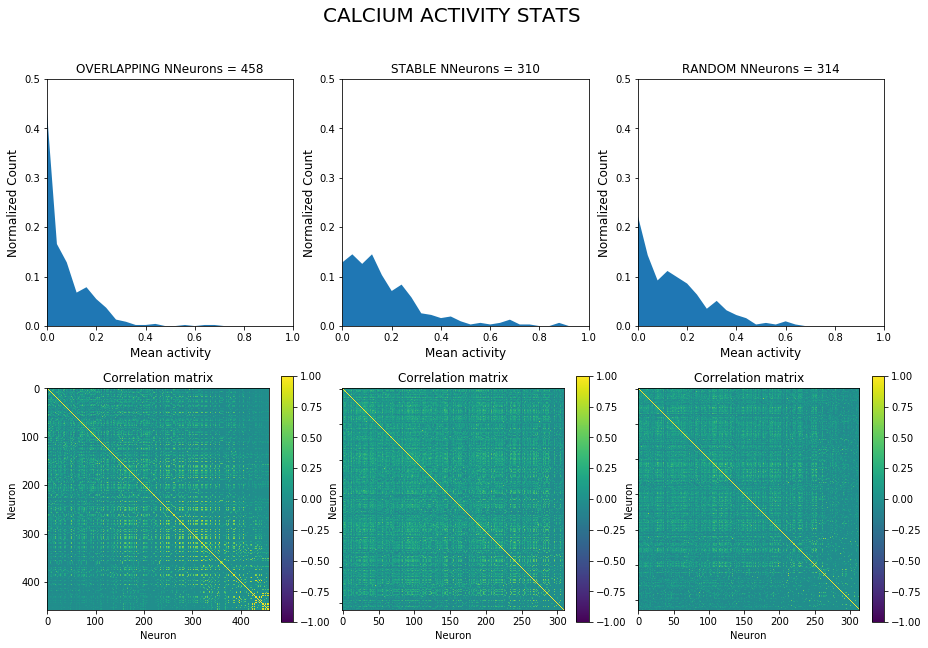

In [127]:
nbins = 25
figure,axes = plt.subplots(2,3)
images = []
for i in range(len(firing_rate_vector)):
    #axes[i].hist(firing_rate_vector[i], bins = np.arange(0,1,1/20))
    [counter,bin_num] = np.histogram(firing_rate_vector[i],bins=np.arange(0,1,1/nbins))
    axes[0,i].fill_between(bin_num[:-1],counter / np.sum(counter))
    axes[0,i].set_ylim(0,0.5)
    axes[0,i].set_xlim(0,1)
    axes[0,i].set_title(task_list[i] + ' NNeurons = ' + f'{len(firing_rate_vector[i])}',fontsize=12)
    axes[0,i].set_xlabel('Mean activity', fontsize = 12)
    axes[0,i].set_ylabel('Normalized Count', fontsize = 12)

    images.append(axes[1,i].imshow(correlation_matrix[i], cmap='viridis'))
    axes[1,i].label_outer()
    
vmin = -1
vmax = 1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
for i in range(len(firing_rate_vector)):
    axes[1,i].set_xlabel('Neuron')
    axes[1,i].set_ylabel('Neuron')
    axes[1,i].set_title('Correlation matrix')
    figure.colorbar(images[i], ax=axes[1,i], orientation='vertical', fraction = 0.05)
    
figure.set_size_inches(15,10)
figure.suptitle('CALCIUM ACTIVITY STATS', fontsize = 20)

figure_dir= figure_path +'mean_activity_task_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'
figure.savefig(figure_dir)

## Analysis for different explored objects

In [128]:
# define all relevant files names
session = session_now
file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{100}' + \
                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                      f'{component_evaluation_v}' + '.' + f'{registration_v}' + '.npy'
time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                      '.' + f'{0}' + '.pkl'
beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '.npy'

In [129]:
##load activity and timeline
activity = np.load(file_directory + file_name_session_1)
timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
timeline_info = pickle.load(timeline_file)
##normalize neural activity
timeline_1 = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_1[i] = timeline_info[i][1]
timeline_1[len(timeline_info)] = activity.shape[1]
neural_activity1 = activity[1:,:]
##downsample neural activity
resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,
                                                                                    re_sf=re_sf)
## LOAD BEHAVIOUR
behaviour = np.load(behaviour_dir + beh_file_name_1)
#c = np.linspace(0, 20, len(behaviour))
reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
resample_timeline = timeline_1/re_sf

In [130]:
## compute mean firing rates
mean_activity = np.mean(resample_neural_activity_mean,axis = 1)

#separate neural activity that belongs to traiing without testing trial
test_position = 42
vector = resample_neural_activity_mean[:, :int(resample_timeline[test_position])]
vector_beh = resample_beh1 [:int(resample_timeline[test_position])]

#define list where data will be saved
mean_activity_list = []
for i in range(6):
    selected_data = vector[:,np.where(vector_beh== i)]
    mean_activity_list.append(np.mean(selected_data,axis=2))


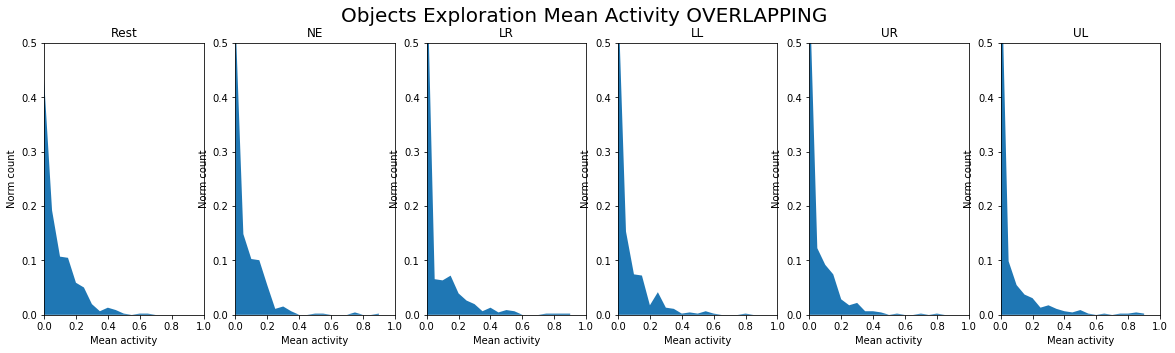

In [131]:
figure , axes = plt.subplots(1, len(mean_activity_list))
nbins = 20
ax_titles = ['Rest','NE','LR','LL','UR','UL']
for i in range(len(mean_activity_list)):
    [counter,bin_num] = np.histogram(mean_activity_list[i],bins=np.arange(0,1,1/nbins))
    axes[i].fill_between(bin_num[:-1],counter / np.sum(counter))
    axes[i].set_ylim(0,0.5)
    axes[i].set_xlim(0,1)
    axes[i].set_title(ax_titles[i], fontsize = 12)
    axes[i].set_xlabel('Mean activity')
    axes[i].set_ylabel('Norm count')

figure.set_size_inches(20,5)
figure.suptitle('Objects Exploration Mean Activity ' + task , fontsize = 20)
figure_dir= figure_path +'mean_activity_objects_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'
figure.savefig(figure_dir)

In [132]:
## load behavioural short and long events
beh_file_short = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_short.npy'
beh_file_long = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_long.npy'
## LOAD BEHAVIOUR SHORT AND LONG
behaviour_short = np.load(behaviour_dir + beh_file_short)
behaviour_long = np.load(behaviour_dir + beh_file_long)
reshape_behaviour_short = np.reshape(behaviour_short[:int(int(behaviour_short.shape[0]/re_sf)*re_sf)],(int(behaviour_short.shape[0]/re_sf),re_sf))
resample_beh_short = np.reshape(scipy.stats.mode(reshape_behaviour_short,axis=1)[0],reshape_behaviour_short.shape[0])
reshape_behaviour_long = np.reshape(behaviour_long[:int(int(behaviour_long.shape[0]/re_sf)*re_sf)],(int(behaviour_long.shape[0]/re_sf),re_sf))
resample_beh_long = np.reshape(scipy.stats.mode(reshape_behaviour_long,axis=1)[0],reshape_behaviour_long.shape[0])

In [133]:
vector_beh_short = resample_beh_short[:int(resample_timeline[len(resample_timeline)-1])]
vector_beh_long = resample_beh_long[:int(resample_timeline[len(resample_timeline)-1])]

#define list where data will be saved
mean_activity_short = []
mean_activity_long = []
for i in [0,1,2,3]:
    selected_data = vector[:,np.where(vector_beh_short== i+2)]
    mean_activity_short.append(np.mean(selected_data,axis=2))
    selected_data = vector[:,np.where(vector_beh_long== i+2)]
    mean_activity_long.append(np.mean(selected_data,axis=2))

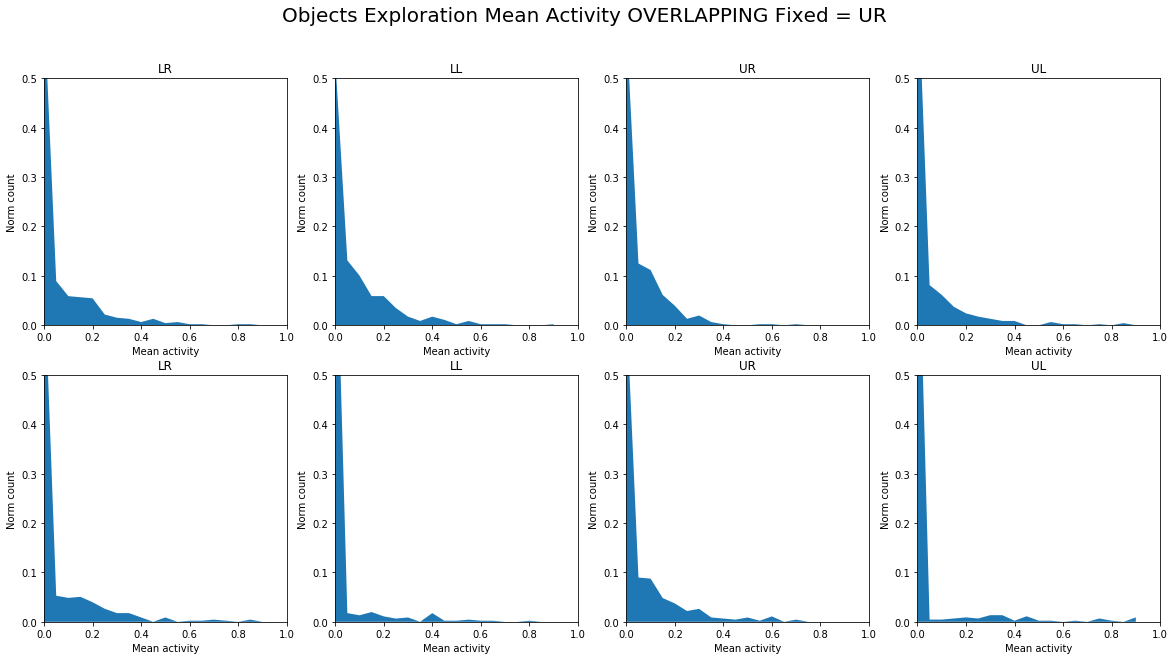

In [135]:
figure , axes = plt.subplots(2, 4)
nbins = 20
ax_titles = ['LR','LL','UR','UL']
for i in [0,1,2,3]:
    [counter,bin_num] = np.histogram(mean_activity_short[i],bins=np.arange(0,1,1/nbins))
    axes[0,i].fill_between(bin_num[:-1],counter / np.sum(counter))
    axes[0,i].set_ylim(0,0.5)
    axes[0,i].set_xlim(0,1)
    axes[0,i].set_title(ax_titles[i], fontsize = 12)
    axes[0,i].set_xlabel('Mean activity')
    axes[0,i].set_ylabel('Norm count')
    
    [counter,bin_num] = np.histogram(mean_activity_long[i],bins=np.arange(0,1,1/nbins))
    axes[1,i].fill_between(bin_num[:-1],counter / np.sum(counter))
    axes[1,i].set_ylim(0,0.5)
    axes[1,i].set_xlim(0,1)
    axes[1,i].set_title(ax_titles[i], fontsize = 12)
    axes[1,i].set_xlabel('Mean activity')
    axes[1,i].set_ylabel('Norm count')

figure.set_size_inches(20,10)
figure.suptitle('Objects Exploration Mean Activity ' + task + ' Fixed = ' + fixed, fontsize = 20)
figure_dir= figure_path +'mean_activity_objects_short_long_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'
figure.savefig(figure_dir)

## Mean activity evolution over days

In [138]:
## Separate neural activity belonging to different days of the experiment, considering as different the resting
# and the trial parts.

neural_activity1_days = []
time_length = np.diff(resample_timeline)
#print(time_length)
#print(len(time_length))
for i in range(int(len(resample_timeline)/10)):
    day_matrix = np.zeros((neural_activity1.shape[0],int(np.sum(time_length[i*10:(i+1)*10:2]))))
    start_time = 0
    for j in range(0,10,2):
        trial = i*10 + j
        if trial < len(resample_timeline)-1:
            day_matrix[:,start_time:start_time+ int(time_length[trial])] = \
                neural_activity1[:,int(resample_timeline[trial]):int(resample_timeline[trial]) + int(time_length[trial])]
            start_time = start_time + int(time_length[trial])
    neural_activity1_days.append(day_matrix)

neural_activity1_resting_days = []
time_length = np.diff(resample_timeline)
for i in range(int(len(resample_timeline)/10)):
    day_matrix = np.zeros((neural_activity1.shape[0],int(np.sum(time_length[i*10+1:(i+1)*10+1:2]))))
    start_time = 0
    for j in range(1,10,2):
        trial = i*10 + j
        if trial < len(resample_timeline)-1:
            day_matrix[:,start_time:start_time+ int(time_length[trial])] = \
                neural_activity1[:,int(resample_timeline[trial]):int(resample_timeline[trial]) + int(time_length[trial])]
            start_time = start_time + int(time_length[trial])
    neural_activity1_resting_days.append(day_matrix)

neural_activity1_resting_testing = neural_activity1[:,int(resample_timeline[-2]):int(resample_timeline[-1])]
neural_activity1_testing = neural_activity1[:,int(resample_timeline[-3]):int(resample_timeline[-2])]


In [143]:
mean_activity_days = []
for i in range(int(len(resample_timeline)/10)):
    mean_activity_days.append(np.mean(neural_activity1_days[i], axis = 1))
mean_activity_days.append(np.mean(neural_activity1_testing,axis=1))

mean_activity_resting_days = []
for i in range(int(len(resample_timeline)/10)):
    mean_activity_resting_days.append(np.mean(neural_activity1_resting_days[i],axis = 1))
mean_activity_resting_days.append(np.mean(neural_activity1_resting_testing, axis = 1))


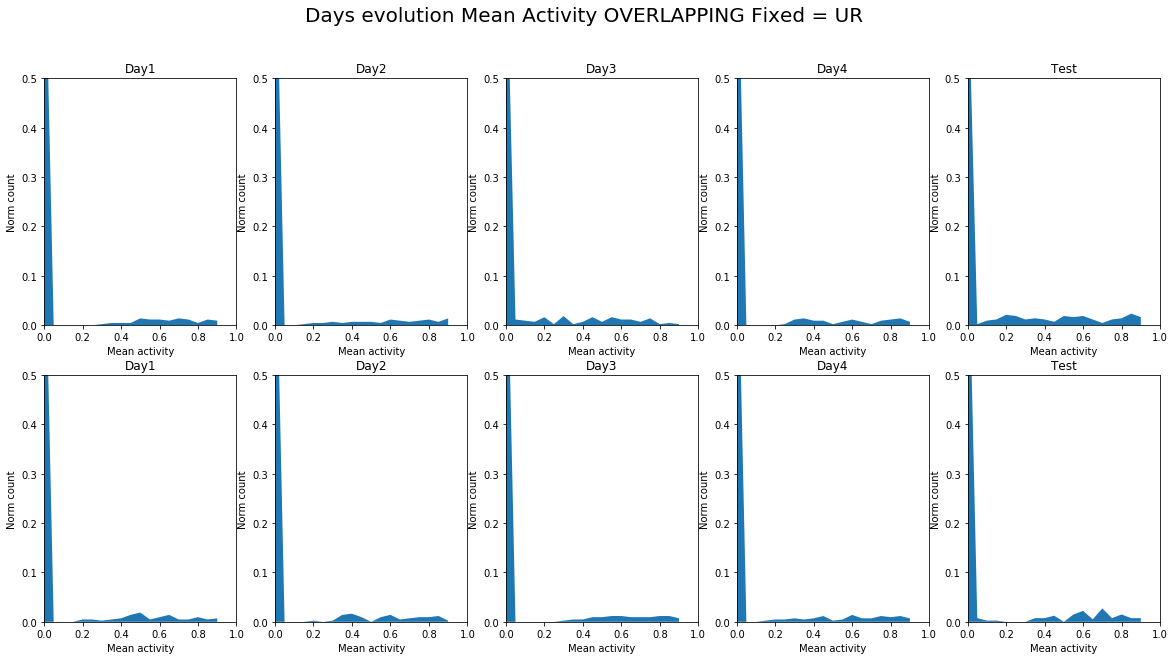

In [152]:
figure , axes = plt.subplots(2, 5)
nbins = 20
ax_titles = ['Day1','Day2','Day3','Day4','Test']
for i in range(5):
    [counter,bin_num] = np.histogram(mean_activity_days[i],bins=np.arange(0,1,1/nbins))
    axes[0,i].fill_between(bin_num[:-1],counter / np.sum(counter))
    axes[0,i].set_ylim(0,0.5)
    axes[0,i].set_xlim(0,1)
    axes[0,i].set_title(ax_titles[i], fontsize = 12)
    axes[0,i].set_xlabel('Mean activity')
    axes[0,i].set_ylabel('Norm count')
    
    [counter,bin_num] = np.histogram(mean_activity_resting_days[i],bins=np.arange(0,1,1/nbins))
    axes[1,i].fill_between(bin_num[:-1],counter / np.sum(counter))
    axes[1,i].set_ylim(0,0.5)
    axes[1,i].set_xlim(0,1)
    axes[1,i].set_title(ax_titles[i], fontsize = 12)
    axes[1,i].set_xlabel('Mean activity')
    axes[1,i].set_ylabel('Norm count')

figure.set_size_inches(20,10)
figure.suptitle('Days evolution Mean Activity ' + task + ' Fixed = ' + fixed, fontsize = 20)
figure_dir= figure_path +'mean_activity_days_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'
figure.savefig(figure_dir)